# I. Parametric vs non-parametric regression

In [1]:
# Some boilerplate code: importing matplotlib and numpy
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

Let us define the random variables $X$ and $Y$ by
$$
f(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = f(X) + \varepsilon,
$$
where $\varepsilon \sim \mathcal{N}(0, 1/4)$ is independent of X

In [2]:
# Simulation of a sample for the distribution defined above
def f(x):
    return (x + x ** 2) / (1. + x ** 2)

n = 1000
sigma = 0.5
X = np.random.randn(n)
Y = f(X) + sigma * np.random.randn(n)

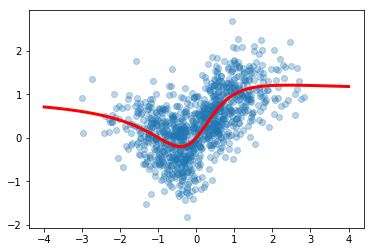

In [3]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.
plt.scatter(X, Y, alpha=0.3)
mesh = np.linspace(-4, 4, 101)
plt.plot(mesh, f(mesh), 'r', linewidth=3)
plt.show()

## Non-parametric regression

In [4]:
# Non-parametric regression function

def reg_non_param(x, bdwidth, x_sample, y_sample):
    """Values of the non-parametric regression of Y wrt X using a Gaussian kernel.

    Parameters
    ----------
    x: numpy array, one dimensional
        Values at which the regression is evaluated
    bdwidth: positive float, value of the bandwidth parameter
    x_sample: numpy array, one dimensional, non-empty
        x values of the sample
    y_sample: numpy array, one dimensional
        y values of the sample, must have the same length as x_sample.    
    """
    def kern(u, x):
        """Gaussian kernel function"""
        return np.exp(-(u[:, np.newaxis] - x) ** 2 / (2 * bdwidth ** 2))

    return np.sum(kern(x_sample, x) * y_sample[:, np.newaxis], axis=0) \
        / np.sum(kern(x_sample, x), axis=0)

Plotting non-parametric regressions of $Y$ with respect to $X$ with different values of the bandwidth:

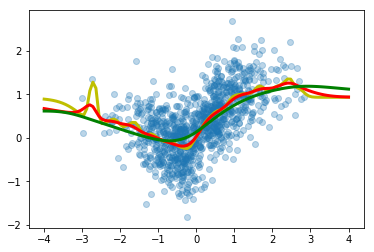

In [5]:
# Plotting the 10 basis functions corresponding to 10 knots equi-spaced on [-3, 3].
plt.scatter(X, Y, alpha=0.3)
plt.plot(mesh, reg_non_param(mesh, 0.1, X, Y), 'y', linewidth=3)
plt.plot(mesh, reg_non_param(mesh, 0.2, X, Y), 'r', linewidth=3)
plt.plot(mesh, reg_non_param(mesh, 0.5, X, Y), 'g', linewidth=3)
plt.show()

## Multiple regression

In [6]:
def basis(knots, x):
    """Values of order-1 B-spline basis functions.
    
    For an increasingly sorted collection of knots and a collection of
    query points x, returns a 2-dimensional array of values, of dimension
    len(x) x len(knots).
    
    Parameters
    ----------
    knots: numpy array, one dimensional, increasingly sorted
        Knots of the B-spline function
    x: numpy array, one dimensional
        Query points where to evaluate the basis functions.
    """
    nb_knots = len(knots)
    diag = np.identity(nb_knots)
    res = np.empty((len(x), nb_knots))
    for i in xrange(nb_knots):
        res[:, i] = np.interp(x, knots, diag[i])
    return res

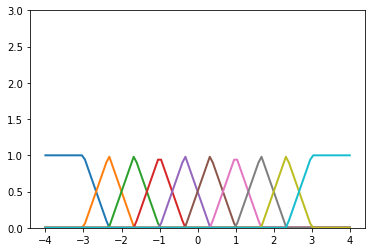

In [7]:
# Plotting the 10 basis functions corresponding to 10 knots equi-spaced on [-3, 3]
basis_len = 10
knots = np.linspace(-3.0, 3.0, basis_len)
plt.plot(mesh, basis(knots, mesh), linewidth=2)
plt.ylim(0.0, 3)
plt.show()

## Experiment on regression methods

#### **1.** Experiment with  
- Perform the piecewise linear regression of $Y$ with respect to $X$, where $X$ and $Y$ are the random variables defined earlier, using a multidimensional regression of $Y$ onto the order-1 basis functions $(b_i(X))_{i \in \{1,\ldots ,k\}}$, and plot the results.


In [8]:
def reg_param_coeffs(knots, x_sample, y_sample):
    """Computes the coefficients of the P-L regression of y_sample wrt. x_sample.
    
    For an increasingly sorted collection of knots and two one-dimensional
    samples x_sample and y_sample, computes the PL-regression.
    
    Parameters
    ----------
    knots: numpy array, one dimensional, increasingly sorted
        Knots of the B-spline function
    x_sample: numpy array, one dimensional
        X sample
    y_sample: numpy array, one dimensional
        Y sample
        
    Notes
    -----
    The length of the X and Y samples must be the same.
    The length of the knots array should be at least one.
    The knots must be increasingly sorted.
    """
    bis = basis(knots, x_sample)
    var = bis.T.dot(bis)
    covar = y_sample.dot(bis)
    return np.linalg.lstsq(var, covar.T)[0]

In [9]:
def eval_piecewise_linear(x, knots, coeffs):
    """Eveluates the piecewise linear function at the specified x for the
    specified knots and coeffs.
    
    This is simply a wrapper around np.interp.
    """
    return np.interp(x, knots, coeffs)

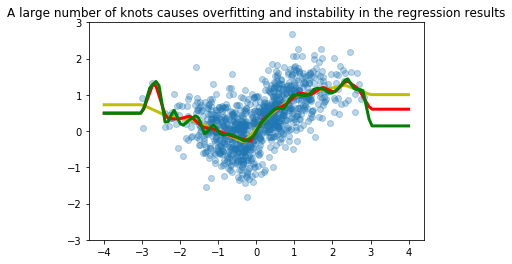

In [10]:
# Plotting the results of the regression with different number of knots.
# Observe the overfitting when using many knots compared to the sample size (green line).

plt.scatter(X, Y, alpha=0.3)

knots1 = np.linspace(-3.0, 3.0, 10)
plt.plot(mesh, eval_piecewise_linear(mesh, knots1, reg_param_coeffs(knots1, X, Y)), 'y', linewidth=3)

knots2 = np.linspace(-3.0, 3.0, 20)
plt.plot(mesh, np.interp(mesh, knots2, reg_param_coeffs(knots2, X, Y)), 'r', linewidth=3)

knots3 = np.linspace(-3.0, 3.0, 30)
plt.plot(mesh, np.interp(mesh, knots3, reg_param_coeffs(knots3, X, Y)), 'g', linewidth=3)

plt.ylim(-3, 3)
plt.title('A large number of knots causes overfitting and instability in the regression results')
plt.show()

#### **2.** Experiment with 
 - The second derivative of a piecewise-linear function being a Dirac comb. The penalization should be the sum of the squares of the weights of those Dirac masses.
 - various kernel functions, bandwidth values, and sample sizes (non-parametric regression),
 - with various sample sizes and number of basis functions (piecewise linear regression). Compare and comment the results.

In [11]:
# Tikhonov-regularized piecewise linear regression.

def second_derivative_on_dirac_basis(knots):
    """
    Computes the coefficients of the second derivative of the basis functions
    on the Dirac comb.
    """
    nb_knots = len(knots)
    res = np.zeros((nb_knots, nb_knots))
    if nb_knots > 1:
        res[0, 0] = -1.0 / (knots[1] - knots[0])
        res[0, 1] = 1.0 / (knots[1] - knots[0])
    for i in xrange(1, nb_knots - 1):
        res[i, i - 1] = (1.0 / (knots[i] - knots[i - 1]))
        res[i, i] = -(1.0 / (knots[i] - knots[i - 1]) + 1.0 / (knots[i + 1] - knots[i]))
        res[i, i + 1] = 1.0 / (knots[i + 1] - knots[i])
    if nb_knots > 1:
        res[nb_knots - 1, nb_knots - 2] = 1.0 / (knots[nb_knots - 1] - knots[nb_knots - 2])
        res[nb_knots - 1, nb_knots - 1] = -1.0 / (knots[nb_knots - 1] - knots[nb_knots - 2])
    return res

def dirac_inner_product(knots, coeffs1, coeffs2):
    """
    Equivalent to the finite-difference approximation for the second derivative.
    """
    nb_knots = len(knots) 
    res = 0.0
    for i in xrange(nb_knots):
        res += 0.5 * (coeffs1[i] * coeffs2[i] + coeffs1[i - 1] * coeffs2[i - 1]) / (knots[i] - knots[i - 1])
    return res

def tikhonov_matrix(knots):
    """Computes the second-order Tikhonov matrix of the B-splines corresponding to specified knots.
    
    Note
    ----
    The specified array of knots must be non-empty and increasingly sorted.
    """
    basis_len = len(knots)
    res = np.zeros((basis_len, basis_len))
    coeffs_on_dirac_basis = second_derivative_on_dirac_basis(knots)
    influence_order = 2
    for i in xrange(basis_len):
        min_j = max(0, i - influence_order)
        max_j = min(basis_len, i + influence_order + 1)
        for j in xrange(min_j, max_j):
            res[i, j] = dirac_inner_product(knots, coeffs_on_dirac_basis[i], coeffs_on_dirac_basis[j])
    return res

In [12]:
def penalized_pl_regression(knots, x_sample, y_sample, tikhonov_factor):
    """Compute the second-order penalized P-L regression of y_sample wrt. x_sample.
    """
    bis = basis(knots, x_sample)
    var = (bis.T).dot(bis) / len(x_sample)
    covar = y_sample.dot(bis) / len(x_sample)
    tikho = tikhonov_matrix(knots)
    
    return np.linalg.lstsq(var + tikhonov_factor * tikho, covar.T)[0]

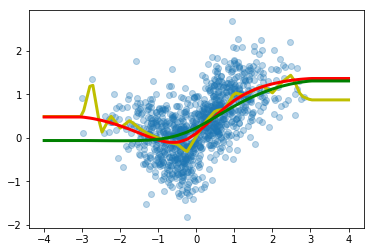

In [13]:
# Plotting the results of the regression with different number of knots.
# Observe the overfitting when using many knots compared to the sample size (green line).

plt.scatter(X, Y, alpha=0.3)
knots = np.linspace(-3.0, 3.0, 25)
plt.plot(mesh, eval_piecewise_linear(mesh, knots, penalized_pl_regression(knots, X, Y, 0.0)), 'y', linewidth=3)
plt.plot(mesh, eval_piecewise_linear(mesh, knots, penalized_pl_regression(knots, X, Y, 0.01)), 'r', linewidth=3)
plt.plot(mesh, eval_piecewise_linear(mesh, knots, penalized_pl_regression(knots, X, Y, 0.1)), 'g', linewidth=3)
plt.show()

# II. American Option Pricing: The American Put in the Black-Scholes model

In [14]:
# Model
S0 = 100
r = 0.05
sigma = 0.2
T = 1.0

# Payoff: ATM Put
K = 100

def payoff(x):
    return np.maximum(K - x, 0)

# Sample size and time discretization
nb_mc = 4000
nb_step = 20

In [15]:
## Utility function for simulating Black-Scholes paths

def bs_path(nb_step, nb_mc, S0, r, sigma, T):
    """Simulate geometric Brownian motion
    
    Parameters
    ----------
    nb_step: integer, greater than 1
        number of time steps
    nb_mc: positive integer
        sample size
    S0: positive float
        starting value
    r: float
        drift
    sigma: float
        volatility
    T: positive float
        maturity
    """
    brownian = np.empty((nb_step + 1, nb_mc))
    brownian[0] = 0.0
    brownian[1:] = np.cumsum(np.random.randn(nb_step, nb_mc), axis=0) * np.sqrt(T / nb_step)

    return S0 * np.exp(sigma * brownian + (r - 0.5 * sigma ** 2) * np.linspace(0.0, T, nb_step + 1)[:, np.newaxis])

## Simulation of a few path of geometric Brownian motion

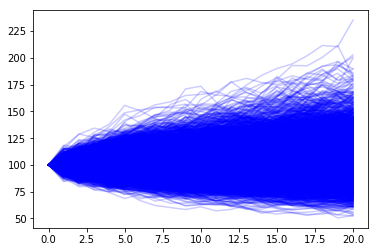

In [16]:
plt.figure()
plt.plot(bs_path(nb_step, nb_mc, S0, r, sigma, T), 'b', alpha=0.2)
plt.show()

## Tsitsiklis-van Roy algorithm

#### We provide a simplistic implementation of the TVR algorithm.

Price from TVR backward induction (non-parametric):  7.05618916018


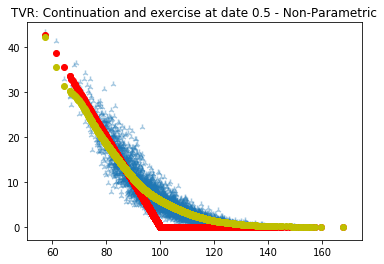

In [17]:
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

# Dynamic programming
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('TVR: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')
    price = np.maximum(exercise, continuation)
print('Price from TVR backward induction (non-parametric): ', np.mean(price))

The price from the backward induction from TVR is generally too high because regression errors accumulate in a positive fashion.

#### **1.** Adapt the TVR code to use the piecewise linear regression method implemented for the previous section.

Price from TVR backward induction (piecewise-linear):  6.02812821926


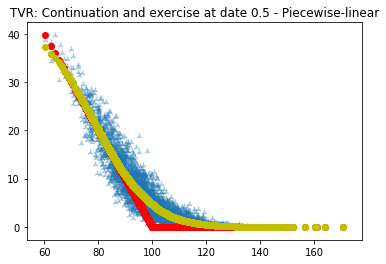

In [18]:
# Version of the TVR backward induction using the Piecewise-linear regression implemented earlier

path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

nb_knots = 20
std = np.std(path[-1])
knots = np.linspace(S0 - 2 * std, S0 + 2 * std, nb_knots)

# Dynamic programming
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    if i != 0:
        tikho = 0.5 * std ** 3 / nb_mc
        coeffs = penalized_pl_regression(knots, path[i], discount * price, tikho)
        continuation = eval_piecewise_linear(path[i], knots, coeffs)
    else:
        continuation = np.mean(discount * price)
    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('TVR: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Piecewise-linear')
    price = np.maximum(exercise, continuation)
print('Price from TVR backward induction (piecewise-linear): ', np.mean(price))

In [19]:
# Corresponding European option price
print('Estimation of the corresponding European option price: ', np.mean(np.exp(-r * T) * payoff(path[-1])))

Estimation of the corresponding European option price:  5.73351115567


#### **2.** For each discretization date, compute the exercise boundary. Draw a plot of the exercise boundary as a function of the date.

In [20]:
# Version of the TVR backward induction where we evaluate the exercise boundary.
# The value used for the exercise boundary is the largest spot value for which exercise
# price is greater than continuation price

path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []
# Dynamic programming
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)
    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    price = np.maximum(exercise, continuation)
frontiers = frontiers[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)

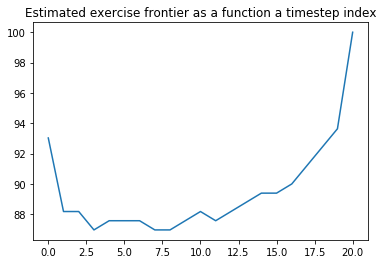

In [21]:
plt.plot(frontiers)
plt.title('Estimated exercise frontier as a function a timestep index')

The exercise frontier is increasing and converges to the strike at maturity. The irregularity of the exercise frontier is due to regression errors varying between time steps.

#### **3.** Perform an independent Monte Carlo simulation using this exercise boundary as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound.

In [22]:
large_nb_mc = 100000
path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)

ssum = 0.0
for i in xrange(large_nb_mc):
    for j in xrange(nb_step + 1):
        if path[j, i] < frontiers[j]:
            ssum += np.exp(- r * j * T / nb_step) * payoff(path[j, i])
            break
    else:
        ssum += np.exp(- r * j * T / nb_step) * payoff(path[j, i])
        
ssum /= large_nb_mc

print(ssum)

6.03844031328


This is a lower bound of the price based on the approximation of the exercise frontier

## Lonstaff-Schwartz Algorithm

#### We provide a simplistic implementation of the LS algorithm.

Price from LS backward induction:  6.30979881556


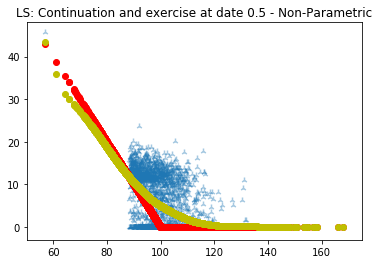

In [23]:
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

# tau is the current estimation of the index of the stopping time
# assuming that we have not exercised so far.
# At the last date, it is equal to the last date index.
tau = np.ones(nb_mc, dtype=np.int) * nb_step

mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []

regressions = []

# Backward induction
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)

    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        # Estimating the continuation value on a regular mesh to compute the exercise frontier.
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation * np.ones(mesh.shape)
    regressions.append(continuation_mesh)
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    exercise_now = exercise > continuation
    tau = np.where(exercise_now, i, tau)
    price = np.where(exercise_now, exercise, discount * price)

    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('LS: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')
        
frontiers = frontiers[::-1]
regressions = regressions[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)

print('Price from LS backward induction: ', np.mean(price))

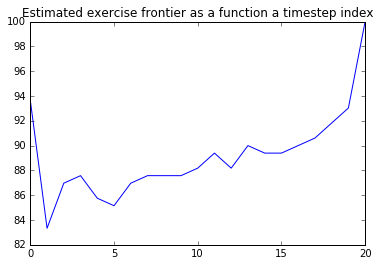

In [24]:
plt.plot(frontiers)
plt.title('Estimated exercise frontier as a function a timestep index')

As expected the scatter plot has more variance in the case of the Longstaff-Schwartz algorithm.

In [25]:
large_nb_mc = 100000
path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)

ssum = 0.0
for i in xrange(large_nb_mc):
    for j in xrange(nb_step + 1):
        if path[j, i] < frontiers[j]:
            ssum += np.exp(- r * j * T / nb_step) * payoff(path[j, i])
            break
    else:
        ssum += np.exp(- r * T) * payoff(path[-1, i])
        
ssum /= large_nb_mc

print(ssum)

6.03975375516


## Dual methods for American option pricing

In [26]:
# Generating a new Monte Carlo sample and computing the Snell envelope at the corresponding values

path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)
snell  = np.empty(path.shape)
disc = np.exp(-r * np.linspace(0.0, T, nb_step + 1))[:, np.newaxis]

for i in range(nb_step):
    snell[i] = np.maximum(payoff(path[i]), eval_piecewise_linear(path[i], mesh, regressions[i]))
snell[nb_step] = payoff(path[nb_step])

snell = disc * snell

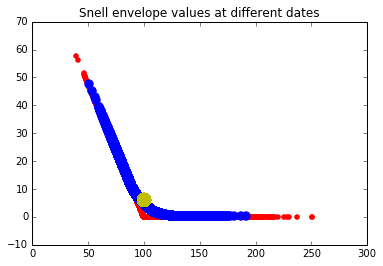

In [27]:
plt.scatter(path[-1], snell[-1], color='r')
plt.scatter(path[10], snell[10], s=70, color='b')
plt.scatter(path[0], snell[0], s=170, color='y')
plt.title('Snell envelope values at different dates')

Extracting the Martingale part of the snell envelope:

- the martingale increments $M_{t_i} - M_{t_{i-1}}$ are equal to $S_{t_i} - E[S_{t_i}|X_{t_{i-1}}]$.
- the conditional expectation in this term can decomposed in two parts, with the indicators of
    - $\tau_{i-1} = t_{i-1}$,
    - $\tau_{i-1} > t_{i-1}$,
    We have, $\mathbb{1}_{\tau_{i-1} > t_{i-1}} E[S_{t_i}|X_{t_{i-1}}] =  \mathbb{1}_{\tau_{i-1} > t_{i-1}} S_{t_{i-1}}$, so that $M_{t_i} - M_{t_{i-1}} = (S_{t_i} - S_{t_{i-1}}) - \mathbb{1}_{\tau_{i-1} = t_{i-1}} (E[S_{t_i}|X_{t_{i-1}}] - S_{t_{i-1}})$.

The benefit of this transformation is that estimating the conditional expectation is only required in $\mathbb{1}_{\tau_{i-1} = t_{i-1}}$, ie. in the exercise region. Bellow, we propose a first implementation of the dual method.

In [28]:
# Extracting the Martingale part of Doob-Meyer decomposition of the Snell envelope.
mart = np.empty(path.shape)

# The martingale starts from zero.
mart[0] = 0
for i in range(nb_step):
    # Compute the exercise region at each date.
    should_exercise = eval_piecewise_linear(path[i], mesh, regressions[i]) < payoff(path[i])

    # Compute the martingale increments / 
    martingale_increment = np.zeros(large_nb_mc)
    for j in range(large_nb_mc):
        if should_exercise[j]:
            # Take a small mc sample from ti to ti + 1
            small_mc = bs_path(1, 100, path[i, j], r, sigma, T / nb_step)
            # Compute the conditional expectation
            if i != nb_step - 1:
                condexp = np.mean(np.maximum(eval_piecewise_linear(small_mc, mesh, regressions[i + 1]),
                                             payoff(small_mc)))
            else:
                condexp = np.mean(payoff(small_mc))
            condexp *= np.exp(-r * T * (i + 1) / nb_step)
            martingale_increment[j] = snell[i + 1][j] - condexp
        else:
            martingale_increment[j] = snell[i + 1][j] - snell[i][j]

    # Add the martingale increment
    mart[i + 1] = mart[i] + martingale_increment

In [29]:
# Use this martingale to evaluate the american option price

price = np.mean(np.max(disc * payoff(path) - mart, axis=0))
print('Dual approach price: ', price)

Dual approach price:  6.22150430471


# III. Some thoughts and more experiments

### Longstaff-Schwartz algorithm - an annotated version

- Use bs_path to generate new paths of Geometric Brownian Motion. 
- Price at maturity for each GBM path is the payoff(terminal value).

In [30]:
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

- Tau is the current estimation of the index of the stopping time. 
- Assuming that we have not exercised so far. 
- At the last date, it is equal to the last date index.

In [31]:
tau = np.ones(path.shape, dtype = np.int) * nb_step

- Initialize mesh, frontiers regressions

In [32]:
mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []
regressions = []

- Backward induction of Longstaff-Schwartz algorithm
- At each iteration:
    - Step 1:
        - Compute following values
            - i: index of current time
            - dicount: discount factor of time value
            - exercise: a vector of exercise payoffs for each GBM path at current time
            - exercise_mesh: a vector of exercise payoffs for each values in mesh 
        
    - Step 2: 
        - Compute the continuation payoff using non-parametric regression
            - Estimating the continuation value on each GBM paths at current time(in order to compute the value of American option).
            - Estimating the continuation value on a regular mesh (in order to compute the exercise frontier).
        - When i=0 (at time 0), the continuation value is the mean of the discount value of GBM paths at time of index 1
    
    - Step 3:
        - Compute the exercise frontier (frontiers)
            - exercise frontier is the rightmost point where exercise_mesh > continuation_mesh
        - Compute the value of American option (price) at current time for each GBM
            - For each GBM path, value of American option at current time is the exercise payoff if exercise payoff is larger than the continuation payoff, otherwise it is the discount value of the last price in the backwards induction
        - Update index of stoppting time for GBM paths (tau)
        - Store regression results (regressions)

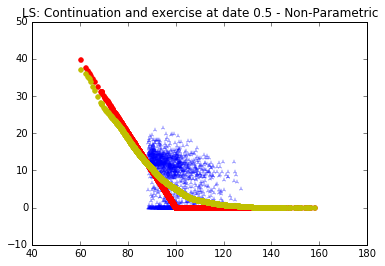

In [33]:
for index in range(nb_step):
    # Step 1
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)
    
    # Step 2
    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation * np.ones(mesh.shape)
    
    # Step 3
    regressions.append(continuation_mesh)
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    exercise_now = exercise > continuation
    tau[i] = np.where(exercise_now, i, tau[i])
    price = np.where(exercise_now, exercise, discount * price)

    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('LS: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')

- Print the American option price using LS backward induction.
- Plot the exercise frontier

Price from LS backward induction:  5.9248654015


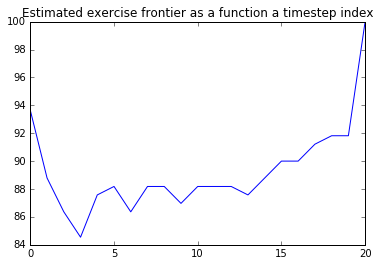

In [34]:
frontiers = frontiers[::-1]
regressions = regressions[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)

print('Price from LS backward induction: ', np.mean(price))

plt.plot(frontiers)
plt.title('Estimated exercise frontier as a function a timestep index')

### Dual methods for American option pricing - an annotated version

- Computing the Snell envelope at the corresponding values
- Snell envelope $S_t$ is defined by
$$
S_t=\sup_{\tau\in\mathcal{T}_{tT}}E[D_{0\tau}F_{\tau}|\mathcal{F}_t]
$$
where $\mathcal{T}_{tT}$ contains all stopping time from time $t$ to $T$, $D$ is discount factor, $F$ is payoff (exercise value) 
- Snell envelope $S_t$ has the dynamic programming formula
$$
S_t=\max[D_{0t}F_t,E[S_{t+1}|\mathcal{F}_t]]
$$
- Here value of Snell envelope is computed using the dynamic programming formula

In [35]:
large_nb_mc = 4000
snell  = np.empty(path.shape)
disc = np.exp(-r * np.linspace(0.0, T, nb_step + 1))[:, np.newaxis]

for i in range(nb_step):
    snell[i] = np.maximum(payoff(path[i]), eval_piecewise_linear(path[i], mesh, regressions[i]))
snell[nb_step] = payoff(path[nb_step])

snell = disc * snell

- Plot Snell envelope value at different dates

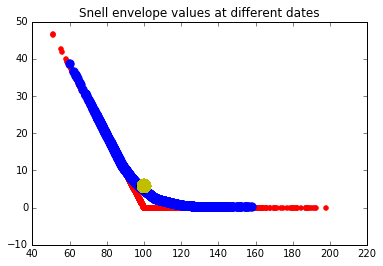

In [36]:
plt.scatter(path[-1], snell[-1], color='r')
plt.scatter(path[10], snell[10], s=70, color='b')
plt.scatter(path[0], snell[0], s=170, color='y')
plt.title('Snell envelope values at different dates')

#### Doob-Meyer decomposition and Roger's duality

- Snell envelope $S_t$ of American option is a supermatingale, which has Doob-Meyer decomposition:
$$
S_t=M_t-A_t
$$
where $M_t$ is a martingale, $A_t$ is an increasing, predictable process.
- Roger's duality formula:
$$
S_t=\sup_{\tau\in\mathcal{T}_{tT}}E[D_{0\tau}F_{\tau}|\mathcal{F}_t]=\inf_{M\in\mathcal{M}_{0t}}E[\sup_{t\leq s\leq T}(D_{ts}F_s-M_s)|\mathcal{F}_t]
$$
where $\mathcal{M}_{0t}$ contains all martingales from time $0$ to $t$
- Here we comput the value of American option using the Roger's duality. First we need to extract the maringale part of the snell envelope.

In [37]:
mart = np.empty(path.shape)
# The martingale starts from zero.
mart[0] = 0

- Extracting the Martingale part of the snell envelope:
    - the martingale increments $M_{t_i} - M_{t_{i-1}}$ are equal to $S_{t_i} - E[S_{t_i}|X_{t_{i-1}}]$.
    - the conditional expectation in this term can decomposed in two parts, with the indicators of
        - $\tau_{i-1} = t_{i-1}$, we have $M_{t_i} - M_{t_{i-1}}=S_{t_i} - E[S_{t_i}|X_{t_{i-1}}]$
        - $\tau_{i-1} > t_{i-1}$,
        We have, $\mathbb{1}_{\tau_{i-1} > t_{i-1}} E[S_{t_i}|X_{t_{i-1}}] =  \mathbb{1}_{\tau_{i-1} > t_{i-1}} S_{t_{i-1}}$, so that $M_{t_i} - M_{t_{i-1}} = (S_{t_i} - S_{t_{i-1}}) - \mathbb{1}_{\tau_{i-1} = t_{i-1}} (E[S_{t_i}|X_{t_{i-1}}] - S_{t_{i-1}})$.

- The benefit of this transformation is that estimating the conditional expectation is only required in $\mathbb{1}_{\tau_{i-1} = t_{i-1}}$, ie. in the exercise region. Below, we propose a first implementation of the dual method.

In [38]:
for i in range(nb_step):
    # Compute the exercise region at each date.
    should_exercise = eval_piecewise_linear(path[i], mesh, regressions[i]) < payoff(path[i])

    # Compute the martingale increments
    martingale_increment = np.zeros(large_nb_mc)
    for j in range(large_nb_mc):
        if should_exercise[j]: # corresponding to tau_{i-1}=t_{i-1}
            # Take a small mc sample from ti to ti + 1
            small_mc = bs_path(1, 100, path[i, j], r, sigma, T / nb_step)
            # Compute the conditional expectation
            if i != nb_step - 1:
                condexp = np.mean(np.maximum(eval_piecewise_linear(small_mc, mesh, regressions[i + 1]),
                                             payoff(small_mc)))
            else:
                condexp = np.mean(payoff(small_mc))
            condexp *= np.exp(-r * T * (i + 1) / nb_step)
            martingale_increment[j] = snell[i + 1][j] - condexp
        else: # corresponding to tau_{i-1}>t_{i-1}
            martingale_increment[j] = snell[i + 1][j] - snell[i][j]

    # Add the martingale increment
    mart[i + 1] = mart[i] + martingale_increment

- Use this martingale to evaluate the American option price

In [39]:
price = np.mean(np.max(disc * payoff(path) - mart, axis=0))
print('Dual approach price: ', price)

Dual approach price:  5.99113532956


## Andersen-Broadie method
- Reusing the exercise policy computed with the Longstaff-Schwartz algorithm, provide an implementation of the dual Andersen-Broadie method for the ATM American Put.
- Compute Snell envelop using Andersen-Broadie method and the exercise policy from the Longstaff-Schwartz algorithm

In [40]:
snell_hat = np.empty(path.shape)

for j in range(nb_mc):
    for i in range(nb_step + 1):

        if tau[i, j] > i:  # tau_i > t_i
            # Take a small mc sample from t_i to tau_i
            small_mc = bs_path(tau[i, j] - i, 100, path[i, j], r, sigma, T / nb_step * (tau[i, j] - i))
            snell_hat[i, j] = np.mean(disc[tau[i, j]] * payoff(small_mc[-1]))

        elif tau[i, j] == i:   # tau_i = t_i
            snell_hat[i, j] = disc[i] * payoff(path[i, j])

- Extracting the martingale part of the snell envelope as the previous dual method:

In [41]:
mart_hat = np.empty(path.shape)
mart_hat[0] = 0

for i in range(nb_step):
    martingale_increment = np.zeros(nb_mc)
    for j in range(nb_mc):
        # should exercise
        if tau[i, j] == i:
            small_mc = bs_path(tau[i+1, j] - i, 100, path[i, j], r, sigma, T / nb_step * (tau[i+1, j] - i))
            condexp = np.mean(disc[tau[i+1, j]] * payoff(small_mc[-1]))
            martingale_increment[j] = snell_hat[i+1, j] - condexp
        else:
            martingale_increment[j] = snell_hat[i+1, j] - snell_hat[i, j]
    mart_hat[i + 1] = mart_hat[i] + martingale_increment

- Use this martingale to evaluate the American option price

In [42]:
price = np.mean(np.max(disc * payoff(path) - mart_hat, axis=0))
print("Dual Andersen-Broadie method price: ", price)

Dual Andersen-Broadie method price:  5.9392366986
